In [2]:
import sys
sys.path.insert(0, '/home/algo/temp/ukfm/python')


In [3]:
from scipy.linalg import block_diag
import ukfm
import numpy as np
import matplotlib
# ukfm.set_matplotlib_config()


In [4]:
MODEL = ukfm.IMUGNSS

# observation frequency (Hz)
GNSS_freq = 1
# load data
omegas, ys, one_hot_ys, t = MODEL.load(GNSS_freq)
N = t.shape[0]
# IMU noise standard deviation (noise is isotropic)
imu_std = np.array([0.01,     # gyro (rad/s)
                    0.05,     # accelerometer (m/s^2)
                    0.000001,  # gyro bias (rad/s^2)
                    0.0001])  # accelerometer bias (m/s^3)
# GNSS noise standard deviation (m)
GNSS_std = 0.05


The state and the input contain the following variables:

```python
states[n].Rot     # 3d orientation (matrix)
states[n].v       # 3d velocity
states[n].p       # 3d position
states[n].b_gyro  # gyro bias
states[n].b_acc   # accelerometer bias
omegas[n].gyro    # vehicle angular velocities
omegas[n].acc     # vehicle specific forces
```

In [5]:
# propagation noise covariance matrix
Q = block_diag(imu_std[0]**2*np.eye(3), imu_std[1]**2*np.eye(3),
               imu_std[2]**2*np.eye(3), imu_std[3]**2*np.eye(3))
# measurement noise covariance matrix
R = GNSS_std**2 * np.eye(3)


In [6]:
# sigma point parameters
alpha = np.array([1e-3, 1e-3, 1e-3, 1e-3, 1e-3])
# for propagation we need the all state
red_idxs = np.arange(15)  # indices corresponding to the full state in P
# for update we need only the state corresponding to the position
up_idxs = np.array([6, 7, 8])

In [7]:
# initial uncertainty matrix
P0 = block_diag(0.01*np.eye(3), 1*np.eye(3), 1*np.eye(3),
                0.001*np.eye(3), 0.001*np.eye(3))
# initial state
state0 = MODEL.STATE(
    Rot=np.eye(3),
    v=np.zeros(3),
    p=np.zeros(3),
    b_gyro=np.zeros(3),
    b_acc=np.zeros(3))


In [8]:
# create the UKF
ukf = ukfm.JUKF(state0=state0, P0=P0, f=MODEL.f, h=MODEL.h, Q=Q[:6, :6],
                phi=MODEL.phi, alpha=alpha, red_phi=MODEL.phi,
                red_phi_inv=MODEL.phi_inv, red_idxs=red_idxs,
                up_phi=MODEL.up_phi, up_idxs=up_idxs)
# set variables for recording estimates along the full trajectory
ukf_states = [state0]
ukf_Ps = np.zeros((N, 15, 15))
ukf_Ps[0] = P0
# the part of the Jacobian that is already known.
G_const = np.zeros((15, 6))
G_const[9:] = np.eye(6)


In [10]:
# measurement iteration number
k = 1
for n in range(1, 2000):
    # propagation
    dt = t[n]-t[n-1]
    ukf.state_propagation(omegas[n-1], dt)
    ukf.F_num(omegas[n-1], dt)
    # we assert the reduced noise covariance for computing Jacobian.
    ukf.Q = Q[:6, :6]
    ukf.G_num(omegas[n-1], dt)
    # concatenate Jacobian
    ukf.G = np.hstack((ukf.G, G_const*dt))
    # we assert the full noise covariance for uncertainty propagation.
    ukf.Q = Q
    ukf.cov_propagation()
    # update only if a measurement is received
    if one_hot_ys[n] == 1:
        ukf.update(ys[k], R)
        k = k + 1
    # save estimates
    ukf_states.append(ukf.state)
    ukf_Ps[n] = ukf.P


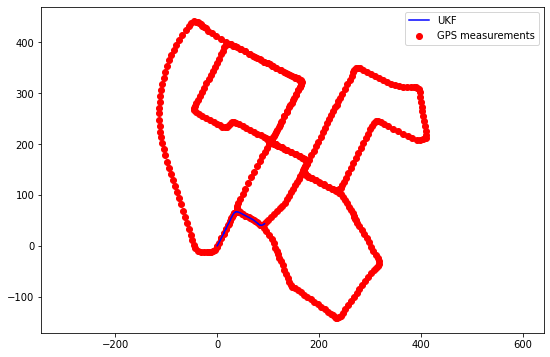

In [11]:
MODEL.plot_results(ukf_states, ys)